# Trảo An Huy 22280041 NLP week 7 REtrain BERT and XLNET on vietnamese dataset, give some comparisons between them and suggest methods to improve.

# Problem
- Use BERT and XLNet to classify sentiment from vietnamese students reviews.

## Download dataset
Vietnamese Students' Feedback Corpus (UIT-VSFC) is the resource consists of over 16,000 sentences which are human-annotated with two different tasks: sentiment-based and topic-based classifications.

[1] Kiet Van Nguyen, Vu Duc Nguyen, Phu Xuan-Vinh Nguyen, Tham Thi-Hong Truong, Ngan Luu-Thuy Nguyen, UIT-VSFC: Vietnamese Students' Feedback Corpus for Sentiment Analysis,  2018 10th International Conference on Knowledge and Systems Engineering (KSE 2018), November 1-3, 2018, Ho Chi Minh City, Vietnam

In [23]:
!pip install -U datasets

In [24]:
pip install -U fsspec datasets


  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
Note: you may need to restart the kernel to use updated packages.


In [25]:
from datasets import load_dataset

dataset = load_dataset("uitnlp/vietnamese_students_feedback")

## Train set exploration

In [26]:
train_set = dataset['train']
train_set

Dataset({
    features: ['sentence', 'sentiment', 'topic'],
    num_rows: 11426
})

In [27]:
train_set[0]

{'sentence': 'slide giáo trình đầy đủ .', 'sentiment': 2, 'topic': 1}

In [28]:
len(train_set)

11426

In [29]:
# Unique labels
set(train_set['sentiment'])

{0, 1, 2}

In [30]:
# Unique labels
set(train_set['topic'])

{0, 1, 2, 3}

## Test set exploration

In [31]:
test_set = dataset['test']
test_set

Dataset({
    features: ['sentence', 'sentiment', 'topic'],
    num_rows: 3166
})

In [32]:
test_set[0]

{'sentence': 'nói tiếng anh lưu loát .', 'sentiment': 2, 'topic': 0}

In [33]:
len(test_set)

3166

# Question:

For both BERT - XLNet and vietnamese texts (this homework) and english texts (previous homework):
- Are there any differences in the evaluating performance in applying those 2 models for 2 datasets, i.e., vietnamese and english ? Analyze and visualize your results to prove your conclusion.
- How to improve the weaker approaches ?

## Are there any differences in the evaluating performance in applying those 2 models for 2 datasets, i.e., vietnamese and english ? Analyze and visualize your results to prove your conclusion.

###Tokenize data
Create a DataLoader
Build or load model
Create a training workflow
Set up hyperparameters for training procedure
Train model
Evaluate model
Infer model

In [34]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    XLNetTokenizer, XLNetForSequenceClassification,
    get_scheduler
)
from torch.optim import AdamW
import re
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [35]:

class Hyperparameters:
    def __init__(self):
        self.MODEL_NAME_BERT = "bert-base-uncased"
        self.MODEL_NAME_XLNET = "xlnet-base-cased"
        self.NUM_LABELS = 3 # multiple classes
        self.MAX_LENGTH = 512
        self.BATCH_SIZE = 16
        self.NUM_EPOCHS = 6
        self.LEARNING_RATE = 2e-5
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_losses = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.eval_precisions = []
        self.eval_recalls = []
        self.eval_f1_scores = []

class DataHandler:
    def __init__(self, dataset_name=None):
        self.dataset_name = dataset_name
        self.raw_datasets = None
        self.train_dataset = None
        self.test_dataset = None

    def load_data(self):
        print(f"Loading dataset: {self.dataset_name}")
        self.raw_datasets = load_dataset(self.dataset_name)

        # # # Lấy mẫu ngẫu nhiên
        # self.train_dataset = self.raw_datasets["train"].shuffle(seed=42).select(range(100))
        # self.test_dataset = self.raw_datasets["test"].shuffle(seed=42).select(range(20))
        # # lấy toàn bộ dữ liệu tập data.
        self.train_dataset = self.raw_datasets["train"]
        self.test_dataset = self.raw_datasets["test"]
        # Đổi tên cột
        rename_map = {"sentence": "text", "sentiment": "label"}
        self.train_dataset = self.train_dataset.rename_columns(rename_map)
        self.test_dataset = self.test_dataset.rename_columns(rename_map)

        print("Dataset loaded.")

    def discover_dataset(self):
        if self.raw_datasets is None:
            print("Dataset not loaded yet. Call load_data() first.")
            return
        print("\nDataset Information:")
        print(self.raw_datasets)
        print("\nTrain dataset features:", self.train_dataset.features)
        print("Number of training examples:", len(self.train_dataset))
        print("Number of testing examples:", len(self.test_dataset))
        print("\nExample from training set:")
        print(self.train_dataset[0])
        print("\nExample from test set:")
        print(self.test_dataset[0])

class Preprocessor:
    def __init__(self):
        pass

    def preprocess_text(self, text):
        # Remove HTML tags
        text = re.sub(r'<br\s*/?>', ' ', text)
        # Remove other special characters or multiple spaces if needed
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def apply_preprocessing(self, example):
        example['text'] = self.preprocess_text(example['text'])
        return example

class TokenizerWrapper:
    def __init__(self, model_name, max_length):
        self.model_name = model_name
        self.max_length = max_length
        if "bert" in model_name.lower():
            self.tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case="uncased" in model_name.lower())
        elif "xlnet" in model_name.lower():
            self.tokenizer = XLNetTokenizer.from_pretrained(model_name, do_lower_case="uncased" in model_name.lower())
        else:
            raise ValueError(f"Unsupported model name for tokenizer: {model_name}")
        print(f"Tokenizer for {model_name} loaded.")

    def tokenize_function(self, examples):
        return self.tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt" # Return PyTorch tensors
        )

class VSFTorchDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

class DataLoaderCreator:
    def __init__(self, tokenizer_wrapper: TokenizerWrapper, preprocessor: Preprocessor):
        self.tokenizer_wrapper = tokenizer_wrapper
        self.preprocessor = preprocessor

    def create_dataloaders(self, train_raw_dataset, test_raw_dataset, batch_size):
        print("Preprocessing and tokenizing data...")

        # Apply preprocessing
        processed_train_dataset = train_raw_dataset.map(self.preprocessor.apply_preprocessing)
        processed_test_dataset = test_raw_dataset.map(self.preprocessor.apply_preprocessing)

        # Apply tokenization
        # Note: Hugging Face map function is smart about batching.
        # We'll tokenize the entire dataset, then convert to PyTorch tensors.
        # For very large datasets, you might tokenize on-the-fly or use map with batched=True more carefully.

        train_texts = [item['text'] for item in processed_train_dataset]
        train_labels = [item['label'] for item in processed_train_dataset]
        test_texts = [item['text'] for item in processed_test_dataset]
        test_labels = [item['label'] for item in processed_test_dataset]

        train_encodings = self.tokenizer_wrapper.tokenizer(train_texts, truncation=True, padding="max_length", max_length=self.tokenizer_wrapper.max_length, return_tensors="pt")
        test_encodings = self.tokenizer_wrapper.tokenizer(test_texts, truncation=True, padding="max_length", max_length=self.tokenizer_wrapper.max_length, return_tensors="pt")

        train_torch_dataset = VSFTorchDataset(train_encodings, train_labels)
        test_torch_dataset = VSFTorchDataset(test_encodings, test_labels)

        train_dataloader = DataLoader(train_torch_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_torch_dataset, batch_size=batch_size, shuffle=False)

        print("DataLoaders created.")
        return train_dataloader, test_dataloader

class ModelBuilder:
    def __init__(self, model_name, num_labels):
        self.model_name = model_name
        self.num_labels = num_labels

    def build_model(self):
        print(f"Building model: {self.model_name}")
        if "bert" in self.model_name.lower():
            model = BertForSequenceClassification.from_pretrained(
                self.model_name,
                num_labels=self.num_labels
            )
        elif "xlnet" in self.model_name.lower():
            model = XLNetForSequenceClassification.from_pretrained(
                self.model_name,
                num_labels=self.num_labels
            )
        else:
            raise ValueError(f"Unsupported model name for building: {self.model_name}")
        print("Model built.")
        return model

class TrainingWorkflow:
    def __init__(self, model, train_dataloader, eval_dataloader, learning_rate, device, num_epochs):
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        self.optimizer = AdamW(model.parameters(), lr=learning_rate)
        self.device = device
        self.num_epochs = num_epochs
        self.loss_fn = nn.CrossEntropyLoss() # Since num_labels=1
        self.train_losses = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.eval_precisions = []
        self.eval_recalls = []
        self.eval_f1_scores = []

        num_training_steps = num_epochs * len(train_dataloader)
        self.lr_scheduler = get_scheduler(
            name="linear", optimizer=self.optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
        )
        self.progress_bar_train = tqdm(range(num_training_steps))
        self.progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        for batch_idx, batch in enumerate(self.train_dataloader):
            self.optimizer.zero_grad()
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device) # Match shape for BCEWithLogitsLoss

            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item()

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()
            self.progress_bar_train.update(1)
            self.progress_bar_train.set_description(f"Train Batch {batch_idx+1}/{len(self.train_dataloader)}, Loss: {loss.item():.4f}")

        avg_train_loss = total_loss / len(self.train_dataloader)
        return avg_train_loss

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch_idx, batch in enumerate(self.eval_dataloader):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                outputs = self.model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['labels'].cpu().numpy())
                self.progress_bar_eval.update(1)
                self.progress_bar_eval.set_description(f"Eval Batch {batch_idx+1}/{len(self.eval_dataloader)}")

        avg_eval_loss = total_loss / len(self.eval_dataloader)
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

        return avg_eval_loss, accuracy, precision, recall, f1

    def train(self):
        print("Starting training...")
        for epoch in range(self.num_epochs):
            print(f"\n--- Epoch {epoch + 1}/{self.num_epochs} ---")
            avg_train_loss = self.train_epoch()
            print(f"Average Training Loss: {avg_train_loss:.4f}")

            avg_eval_loss, accuracy, precision, recall, f1 = self.evaluate()
            print(f"Average Evaluation Loss: {avg_eval_loss:.4f}")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
            self.train_losses.append(avg_train_loss)
            self.eval_losses.append(avg_eval_loss)
            self.eval_accuracies.append(accuracy)
            self.eval_precisions.append(precision)
            self.eval_recalls.append(recall)
            self.eval_f1_scores.append(f1)
        print("Training complete.")

    def plot_metrics(self):
        epochs = range(1, self.num_epochs + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.train_losses, 'bo-', label='Train Loss')
        plt.plot(epochs, self.eval_losses, 'ro-', label='Eval Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.eval_accuracies, 'go-', label='Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.plot(epochs, self.eval_precisions, 'co-', label='Precision')
        plt.plot(epochs, self.eval_recalls, 'mo-', label='Recall')
        plt.title('Precision & Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(epochs, self.eval_f1_scores, 'yo-', label='F1 Score')
        plt.title('F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


class InferenceHandler:
    def __init__(self, model, tokenizer_wrapper: TokenizerWrapper, device, max_length):
        self.model = model.to(device)
        self.tokenizer_wrapper = tokenizer_wrapper
        self.device = device
        self.max_length = max_length
        self.model.eval() # Set model to evaluation mode

    def predict(self, text):
        preprocessor = Preprocessor()
        processed_text = preprocessor.preprocess_text(text)

        inputs = self.tokenizer_wrapper.tokenizer(
            processed_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Shape: [1, num_labels]
            probs = torch.softmax(logits, dim=1).squeeze()  # Shape: [num_labels]
            prediction = torch.argmax(probs).item()

        return {
            "text": text,
            "processed_text": processed_text,
            "probabilities": probs.tolist(),
            "prediction": prediction,
        }

    def plot_metrics(self):
        epochs = range(1, self.num_epochs + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.train_losses, 'bo-', label='Train Loss')
        plt.plot(epochs, self.eval_losses, 'ro-', label='Eval Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.eval_accuracies, 'go-', label='Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.plot(epochs, self.eval_precisions, 'co-', label='Precision')
        plt.plot(epochs, self.eval_recalls, 'mo-', label='Recall')
        plt.title('Precision & Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(epochs, self.eval_f1_scores, 'yo-', label='F1 Score')
        plt.title('F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


In [36]:
class InferencePipeline:
    def __init__(self, model, tokenizer_wrapper: TokenizerWrapper, device, max_length):
        self.model = model.to(device)
        self.tokenizer_wrapper = tokenizer_wrapper
        self.device = device
        self.max_length = max_length
        self.model.eval() # Set model to evaluation mode

    def predict(self, text):
        preprocessor = Preprocessor()
        processed_text = preprocessor.preprocess_text(text)

        # Correctly use the tokenizer attribute from the TokenizerWrapper instance
        inputs = self.tokenizer_wrapper.tokenizer(
            processed_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).squeeze() # Squeeze for single input
            prediction = torch.argmax(probs).item()

        return {
            "text": text,
            "processed_text": processed_text, # Text after preprocessing, before tokenization
            "probabilities": probs.tolist(),
            "prediction": prediction,
        }

### 1. Load & discover dataset

In [37]:
# 1. Load & discover dataset
data_handler = DataHandler(dataset_name="uitnlp/vietnamese_students_feedback")
data_handler.load_data()
data_handler.discover_dataset()


Loading dataset: uitnlp/vietnamese_students_feedback
Dataset loaded.

Dataset Information:
DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 3166
    })
})

Train dataset features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None), 'topic': ClassLabel(names=['lecturer', 'training_program', 'facility', 'others'], id=None)}
Number of training examples: 11426
Number of testing examples: 3166

Example from training set:
{'text': 'slide giáo trình đầy đủ .', 'label': 2, 'topic': 1}

Example from test set:
{'text': 'nói tiếng anh lưu loát .', 'label': 2, 'topic': 0}


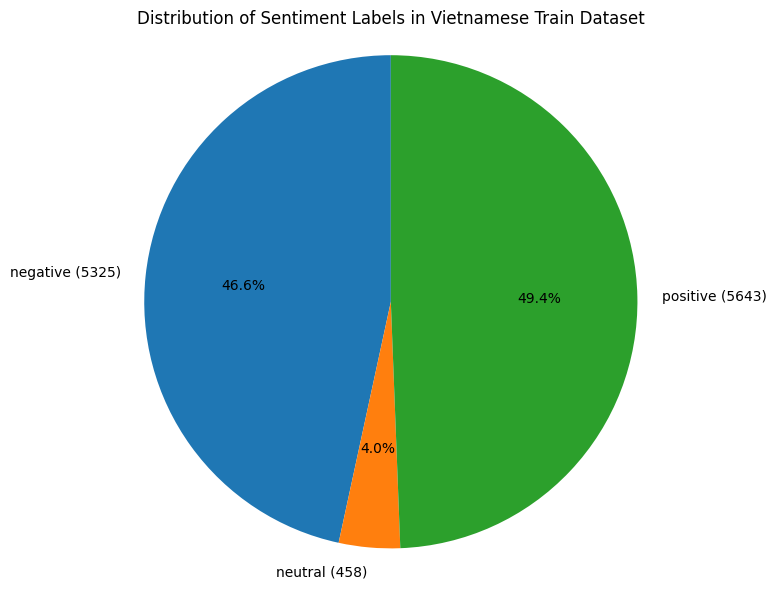

In [38]:
import matplotlib.pyplot as plt
from collections import Counter
# --- Vietnamese Train Dataset Sentiment Distribution ---
sentiments_train_vi = [item['label'] for item in data_handler.train_dataset]
sentiment_counts_train_vi = Counter(sentiments_train_vi)
labels_map_vi_names = data_handler.train_dataset.features['label'].names
sizes_train_vi = [sentiment_counts_train_vi[i] for i in range(len(labels_map_vi_names))]
actual_labels_train_vi = [f"{labels_map_vi_names[i]} ({sentiment_counts_train_vi[i]})" for i in range(len(labels_map_vi_names))]
plt.figure(figsize=(7, 7))
plt.pie(sizes_train_vi, labels=actual_labels_train_vi, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentiment Labels in Vietnamese Train Dataset')
plt.axis('equal')
plt.show()

In [39]:
## setting configuration
config = Hyperparameters()

In [40]:
# 2. Preprocess data (Preprocessor class will be used within DataLoaderCreator)
preprocessor = Preprocessor()

In [41]:
# 3. Tokenize data (TokenizerWrapper class will be used within DataLoaderCreator)
tokenizer_wrapper_BERT = TokenizerWrapper(model_name=config.MODEL_NAME_BERT, max_length=config.MAX_LENGTH)


Tokenizer for bert-base-uncased loaded.


### Train By BERT

#### 4. Tokenizer data.

In [42]:
# 4. Tokenize data (TokenizerWrapper class will be used within DataLoaderCreator)
tokenizer_wrapper_BERT = TokenizerWrapper(model_name=config.MODEL_NAME_BERT, max_length=config.MAX_LENGTH)

Tokenizer for bert-base-uncased loaded.


#### 5. Create DataLoader

In [43]:
dataloader_creator_BERT = DataLoaderCreator(tokenizer_wrapper_BERT, preprocessor)



In [44]:
train_loader, test_loader = dataloader_creator_BERT.create_dataloaders(
    data_handler.train_dataset,
    data_handler.test_dataset,
    config.BATCH_SIZE
)

Preprocessing and tokenizing data...


Map:   0%|          | 0/11426 [00:00<?, ? examples/s]

Map:   0%|          | 0/3166 [00:00<?, ? examples/s]

DataLoaders created.


### 6. Build or load model

In [45]:
# 6. Build or load model
model_builder = ModelBuilder(model_name=config.MODEL_NAME_BERT, num_labels=config.NUM_LABELS)
bert_model = model_builder.build_model()

Building model: bert-base-uncased


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model built.


### 7. Create a training workflow, Set up hyperparameters, Train model

In [46]:
# 7. Create a training workflow, Set up hyperparameters, Train model
BERT_trainer = TrainingWorkflow(
    model=bert_model,
    train_dataloader=train_loader,
    eval_dataloader=test_loader,
    learning_rate=config.LEARNING_RATE,
    device=config.DEVICE,
    num_epochs=config.NUM_EPOCHS
)
BERT_trainer.train()

  0%|          | 0/4290 [00:00<?, ?it/s]

  0%|          | 0/1188 [00:00<?, ?it/s]

Starting training...

--- Epoch 1/6 ---
Average Training Loss: 0.4255
Average Evaluation Loss: 0.3583
Accuracy: 0.8702
Precision: 0.7854, Recall: 0.6332, F1-score: 0.6348

--- Epoch 2/6 ---
Average Training Loss: 0.2701
Average Evaluation Loss: 0.3389
Accuracy: 0.8942
Precision: 0.8304, Recall: 0.6825, F1-score: 0.7052

--- Epoch 3/6 ---
Average Training Loss: 0.2055
Average Evaluation Loss: 0.3411
Accuracy: 0.8932
Precision: 0.7609, Recall: 0.7534, F1-score: 0.7567

--- Epoch 4/6 ---
Average Training Loss: 0.1544
Average Evaluation Loss: 0.3630
Accuracy: 0.8964
Precision: 0.7693, Recall: 0.7577, F1-score: 0.7626

--- Epoch 5/6 ---
Average Training Loss: 0.1129
Average Evaluation Loss: 0.3679
Accuracy: 0.9005
Precision: 0.7779, Recall: 0.7333, F1-score: 0.7498

--- Epoch 6/6 ---
Average Training Loss: 0.0816
Average Evaluation Loss: 0.3938
Accuracy: 0.9011
Precision: 0.7840, Recall: 0.7446, F1-score: 0.7600
Training complete.


#### 8. Evaluate model (evaluation is part of the training loop)

In [47]:
# 8. Evaluate model (evaluation is part of the training loop)
print("\nFinal evaluation on the test set:")
avg_eval_loss, accuracy, precision, recall, f1 = BERT_trainer.evaluate() # Run one last time
print(f"Average Evaluation Loss: {avg_eval_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Final evaluation on the test set:
Average Evaluation Loss: 0.3938
Accuracy: 0.9011
Precision: 0.7840, Recall: 0.7446, F1-score: 0.7600


#### 9. Infer BERT model

In [48]:
# 9. Infer model
print("\n--- Inference Examples (Using BERT) ---")
bert_inference_handler = InferenceHandler(
    model=bert_model,
    tokenizer_wrapper=tokenizer_wrapper_BERT, # Use the BERT tokenizer wrapper
    device=config.DEVICE,
    max_length=config.MAX_LENGTH
)

example_texts = []
actual_labels_for_examples = []

if data_handler.test_dataset and len(data_handler.test_dataset) > 0:
    # Try to show up to 40 examples, or fewer if the test set is smaller
    num_examples_to_show = min(40, len(data_handler.test_dataset))
    print(f"Attempting to show predictions for {num_examples_to_show} examples from the test set.")
    for i in range(num_examples_to_show):
        example_texts.append(data_handler.test_dataset[i]['text'])
        actual_labels_for_examples.append(data_handler.test_dataset[i]['label'])
else:
    # Fallback examples if test_dataset is empty or not loaded as expected
    # This fallback will only provide 3 examples, as defined.
    print("Test dataset is empty or not loaded as expected. Using fallback examples.")
    example_texts = [
        "Bài giảng rất hay và dễ hiểu.", # Expected: positive (2)
        "Môn học này cũng bình thường, không có gì đặc sắc.", # Expected: neutral (1)
        "Tôi không thích cách dạy này lắm, giáo viên nói nhanh quá." # Expected: negative (0)
    ]
    actual_labels_for_examples = [2, 1, 0] # Corresponding expected labels for fallback

# Get label names from the dataset features
label_map_inv = {i: name for i, name in enumerate(data_handler.train_dataset.features['label'].names)}

for i, text in enumerate(example_texts):
    print(f"\n========== Example {i+1} ==========")
    result = bert_inference_handler.predict(text)

    predicted_label_id = result['prediction']
    predicted_label_name = label_map_inv.get(predicted_label_id, f"Unknown ID: {predicted_label_id}")

    print(f"Original Text: {result['text']}")
    # The 'processed_text' in InferenceHandler is the text after regex preprocessing,
    # not after tokenization and decoding.
    print(f"Processed Text (before tokenization): {result['processed_text']}")
    print(f"Probabilities: {[f'{p:.4f}' for p in result['probabilities']]}") # Formatted probabilities
    print(f"Predicted Label ID: {predicted_label_id}")
    print(f"Predicted Label Name: {predicted_label_name}")

    if i < len(actual_labels_for_examples):
        actual_label_id = actual_labels_for_examples[i]
        actual_label_name = label_map_inv.get(actual_label_id, f"Unknown ID: {actual_label_id}")
        print(f"Actual Label ID (from test set): {actual_label_id}")
        print(f"Actual Label Name (from test set): {actual_label_name}")


--- Inference Examples (Using BERT) ---
Attempting to show predictions for 40 examples from the test set.

========== Example 1 ==========
Original Text: nói tiếng anh lưu loát .
Processed Text (before tokenization): nói tiếng anh lưu loát .
Probabilities: ['0.0044', '0.0155', '0.9801']
Predicted Label ID: 2
Predicted Label Name: positive
Actual Label ID (from test set): 2
Actual Label Name (from test set): positive

========== Example 2 ==========
Original Text: giáo viên rất vui tính .
Processed Text (before tokenization): giáo viên rất vui tính .
Probabilities: ['0.0007', '0.0006', '0.9987']
Predicted Label ID: 2
Predicted Label Name: positive
Actual Label ID (from test set): 2
Actual Label Name (from test set): positive

========== Example 3 ==========
Original Text: cô max có tâm .
Processed Text (before tokenization): cô max có tâm .
Probabilities: ['0.0005', '0.0010', '0.9985']
Predicted Label ID: 2
Predicted Label Name: positive
Actual Label ID (from test set): 2
Actual Label 

#### 10. Plot diagram.

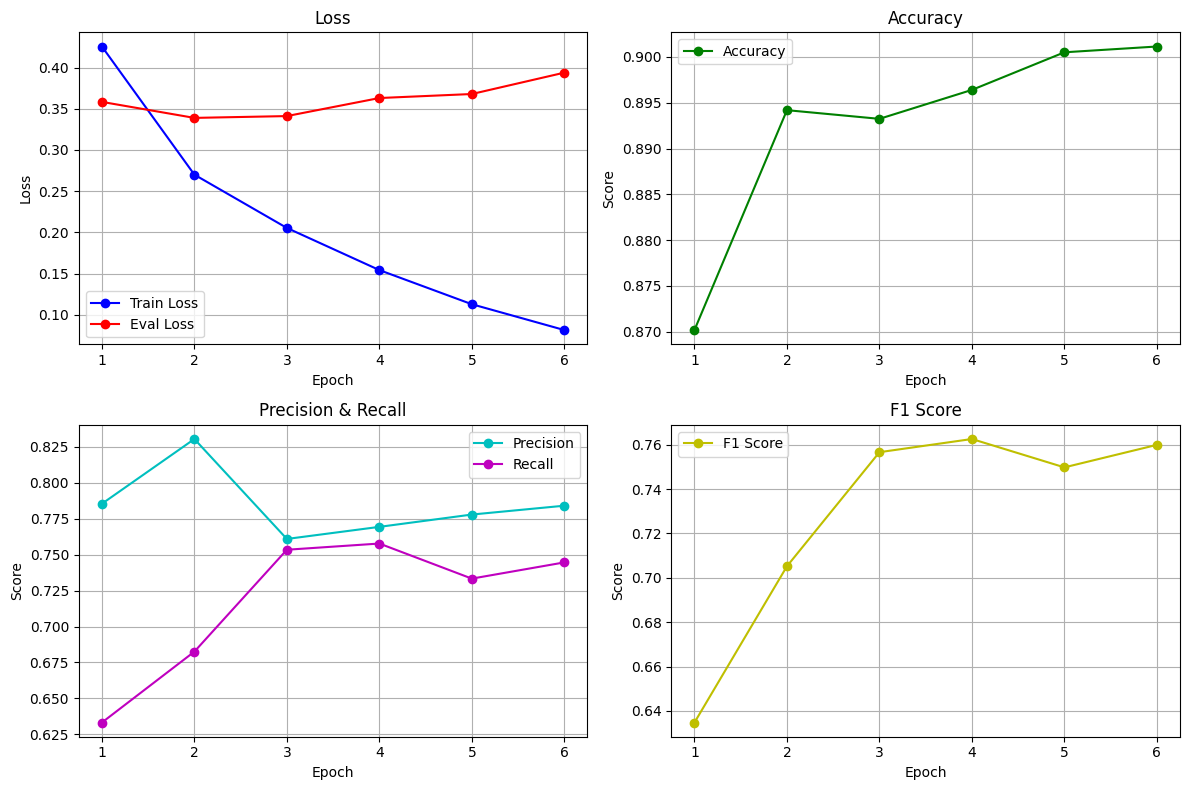

In [49]:
BERT_trainer.plot_metrics()

# 9. Draw Confuse matrix.

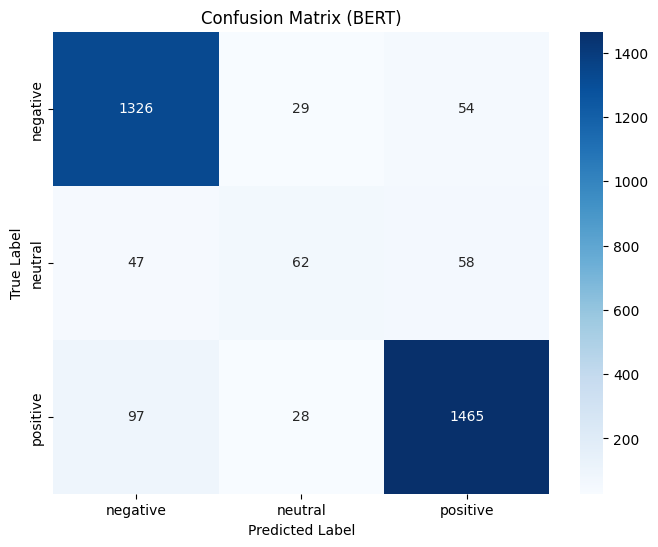

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

bert_model.eval()
all_bert_preds = []
all_bert_labels = []
with torch.no_grad():
    for batch in BERT_trainer.eval_dataloader:
        input_ids = batch['input_ids'].to(BERT_trainer.device)
        attention_mask = batch['attention_mask'].to(BERT_trainer.device)
        labels = batch['labels'].to(BERT_trainer.device)

        outputs = BERT_trainer.model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_bert_preds.extend(preds.cpu().numpy())
        all_bert_labels.extend(labels.cpu().numpy())
label_names = data_handler.train_dataset.features['label'].names
cm_bert = confusion_matrix(all_bert_labels, all_bert_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names) # Use dynamic label names
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT)')
plt.show()

### Train BY XLNET

### 3. Tokenize data (TokenizerWrapper class will be used within DataLoaderCreator)

In [51]:
# 3. Tokenize data (TokenizerWrapper class will be used within DataLoaderCreator)
tokenizer_wrapper_XLNET = TokenizerWrapper(model_name=config.MODEL_NAME_XLNET, max_length=config.MAX_LENGTH)


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

Tokenizer for xlnet-base-cased loaded.


#### 4. Tokenize data (TokenizerWrapper class will be used within DataLoaderCreator)

In [52]:
# 4. Tokenize data (TokenizerWrapper class will be used within DataLoaderCreator)
tokenizer_wrapper_XLNET = TokenizerWrapper(model_name=config.MODEL_NAME_XLNET, max_length=config.MAX_LENGTH)

Tokenizer for xlnet-base-cased loaded.


### 5. Create DataLoader

In [53]:
# 5. Create DataLoader
dataloader_creator_XLNET  = DataLoaderCreator(tokenizer_wrapper_XLNET, preprocessor)
train_loader, test_loader = dataloader_creator_XLNET.create_dataloaders(
    data_handler.train_dataset,
    data_handler.test_dataset,
    config.BATCH_SIZE
)

Preprocessing and tokenizing data...
DataLoaders created.


### 6. Build or load model


In [54]:
# 6. Build or load model
model_builder = ModelBuilder(model_name=config.MODEL_NAME_XLNET, num_labels=config.NUM_LABELS)
xlnet_model = model_builder.build_model()

Building model: xlnet-base-cased


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model built.


###7. Create a training workflow, Set up hyperparameters, Train model

In [55]:
# 7. Create a training workflow, Set up hyperparameters, Train model
XLNET_trainer = TrainingWorkflow(
    model=xlnet_model,
    train_dataloader=train_loader,
    eval_dataloader=test_loader,
    learning_rate=config.LEARNING_RATE,
    device=config.DEVICE,
    num_epochs=config.NUM_EPOCHS
)
XLNET_trainer.train()

  0%|          | 0/4290 [00:00<?, ?it/s]

  0%|          | 0/1188 [00:00<?, ?it/s]

Starting training...

--- Epoch 1/6 ---


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Average Training Loss: 0.4640
Average Evaluation Loss: 0.3842
Accuracy: 0.8636
Precision: 0.7750, Recall: 0.6274, F1-score: 0.6270

--- Epoch 2/6 ---
Average Training Loss: 0.3197
Average Evaluation Loss: 0.3498
Accuracy: 0.8834
Precision: 0.7662, Recall: 0.6643, F1-score: 0.6792

--- Epoch 3/6 ---
Average Training Loss: 0.2579
Average Evaluation Loss: 0.3562
Accuracy: 0.8923
Precision: 0.7842, Recall: 0.6799, F1-score: 0.6981

--- Epoch 4/6 ---
Average Training Loss: 0.2162
Average Evaluation Loss: 0.3376
Accuracy: 0.8920
Precision: 0.7887, Recall: 0.6851, F1-score: 0.7049

--- Epoch 5/6 ---
Average Training Loss: 0.1813
Average Evaluation Loss: 0.3541
Accuracy: 0.8973
Precision: 0.7834, Recall: 0.7085, F1-score: 0.7290

--- Epoch 6/6 ---
Average Training Loss: 0.1577
Average Evaluation Loss: 0.3673
Accuracy: 0.8999
Precision: 0.7743, Recall: 0.7150, F1-score: 0.7337
Training complete.


## 8. Evaluate model (evaluation is part of the training loop)

In [56]:
# 8. Evaluate model (evaluation is part of the training loop)
print("\nFinal evaluation on the test set:")
avg_eval_loss, accuracy, precision, recall, f1 = XLNET_trainer.evaluate() # Run one last time
print(f"Average Evaluation Loss: {avg_eval_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Final evaluation on the test set:
Average Evaluation Loss: 0.3673
Accuracy: 0.8999
Precision: 0.7743, Recall: 0.7150, F1-score: 0.7337


### 9. Infer model

In [57]:
# 9. Infer model
print("\n--- Inference Examples (Using BERT) ---")
bert_inference_handler = InferenceHandler(
    model=bert_model,
    tokenizer_wrapper=tokenizer_wrapper_XLNET,
    device=config.DEVICE,
    max_length=config.MAX_LENGTH
)

example_texts = []
actual_labels_for_examples = []

if data_handler.test_dataset and len(data_handler.test_dataset) > 0:
    # Try to show up to 40 examples, or fewer if the test set is smaller
    num_examples_to_show = min(40, len(data_handler.test_dataset))
    print(f"Attempting to show predictions for {num_examples_to_show} examples from the test set.")
    for i in range(num_examples_to_show):
        example_texts.append(data_handler.test_dataset[i]['text'])
        actual_labels_for_examples.append(data_handler.test_dataset[i]['label'])
else:
    # Fallback examples if test_dataset is empty or not loaded as expected
    # This fallback will only provide 3 examples, as defined.
    print("Test dataset is empty or not loaded as expected. Using fallback examples.")
    example_texts = [
        "Bài giảng rất hay và dễ hiểu.", # Expected: positive (2)
        "Môn học này cũng bình thường, không có gì đặc sắc.", # Expected: neutral (1)
        "Tôi không thích cách dạy này lắm, giáo viên nói nhanh quá." # Expected: negative (0)
    ]
    actual_labels_for_examples = [2, 1, 0] # Corresponding expected labels for fallback

# Get label names from the dataset features
label_map_inv = {i: name for i, name in enumerate(data_handler.train_dataset.features['label'].names)}

for i, text in enumerate(example_texts):
    print(f"\n========== Example {i+1} ==========")
    result = bert_inference_handler.predict(text)

    predicted_label_id = result['prediction']
    predicted_label_name = label_map_inv.get(predicted_label_id, f"Unknown ID: {predicted_label_id}")

    print(f"Original Text: {result['text']}")
    # The 'processed_text' in InferenceHandler is the text after regex preprocessing,
    # not after tokenization and decoding.
    print(f"Processed Text (before tokenization): {result['processed_text']}")
    print(f"Probabilities: {[f'{p:.4f}' for p in result['probabilities']]}") # Formatted probabilities
    print(f"Predicted Label ID: {predicted_label_id}")
    print(f"Predicted Label Name: {predicted_label_name}")

    if i < len(actual_labels_for_examples):
        actual_label_id = actual_labels_for_examples[i]
        actual_label_name = label_map_inv.get(actual_label_id, f"Unknown ID: {actual_label_id}")
        print(f"Actual Label ID (from test set): {actual_label_id}")
        print(f"Actual Label Name (from test set): {actual_label_name}")


--- Inference Examples (Using BERT) ---
Attempting to show predictions for 40 examples from the test set.

========== Example 1 ==========
Original Text: nói tiếng anh lưu loát .
Processed Text (before tokenization): nói tiếng anh lưu loát .
Probabilities: ['0.7867', '0.1127', '0.1005']
Predicted Label ID: 0
Predicted Label Name: negative
Actual Label ID (from test set): 2
Actual Label Name (from test set): positive

========== Example 2 ==========
Original Text: giáo viên rất vui tính .
Processed Text (before tokenization): giáo viên rất vui tính .
Probabilities: ['0.7919', '0.0704', '0.1377']
Predicted Label ID: 0
Predicted Label Name: negative
Actual Label ID (from test set): 2
Actual Label Name (from test set): positive

========== Example 3 ==========
Original Text: cô max có tâm .
Processed Text (before tokenization): cô max có tâm .
Probabilities: ['0.8069', '0.1047', '0.0885']
Predicted Label ID: 0
Predicted Label Name: negative
Actual Label ID (from test set): 2
Actual Label 

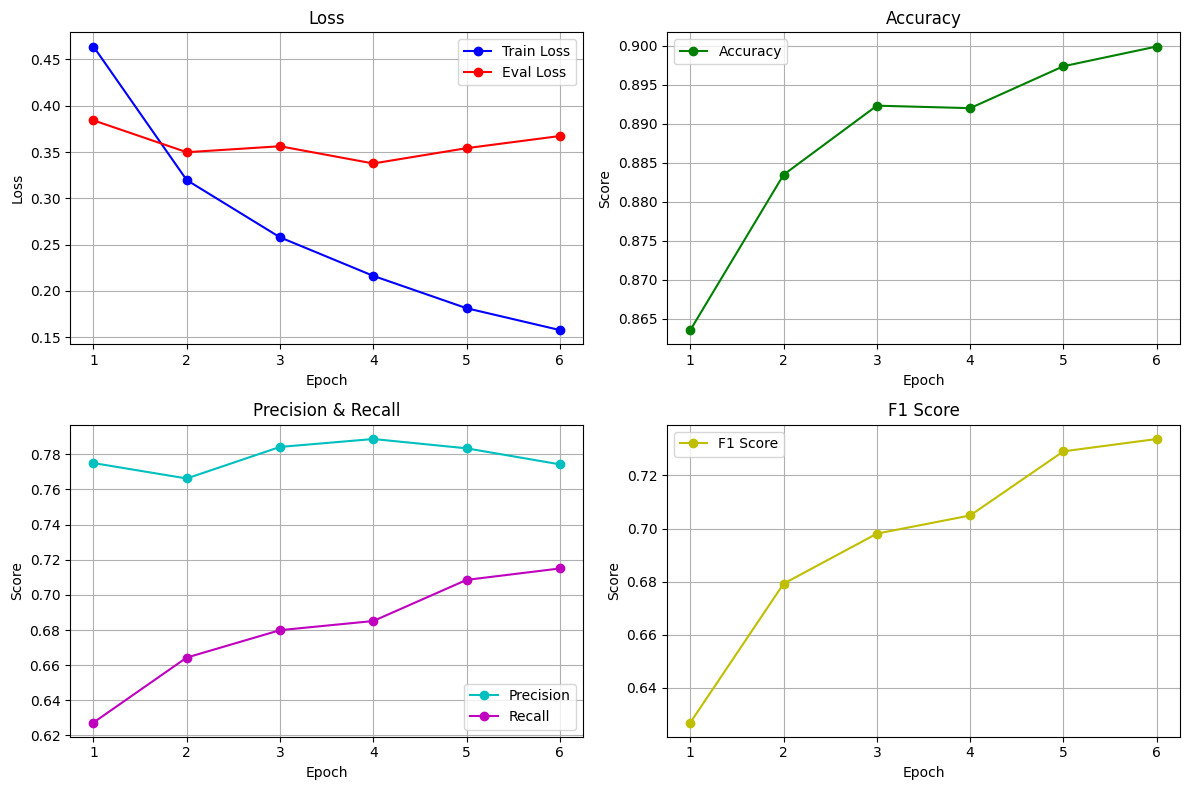

In [58]:
XLNET_trainer.plot_metrics()


Confusion Matrix for XLNet Model:


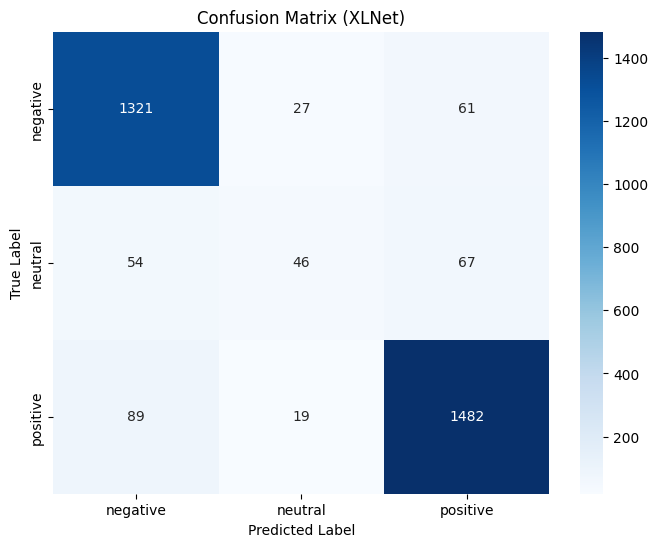

In [59]:
# For the trained XLNET model:
print("\nConfusion Matrix for XLNet Model:")
# Re-evaluate to get the predictions on the test set
# No need to re-evaluate the whole model if you just need predictions for the confusion matrix
# xlnet_eval_loss, xlnet_accuracy, xlnet_precision, xlnet_recall, xlnet_f1 = XLNET_trainer.evaluate()

# Get the preds and labels specifically for the confusion matrix after training
xlnet_model.eval()
all_xlnet_preds = []
all_xlnet_labels = []
with torch.no_grad():
    for batch in XLNET_trainer.eval_dataloader:
        input_ids = batch['input_ids'].to(XLNET_trainer.device)
        attention_mask = batch['attention_mask'].to(XLNET_trainer.device)
        # Removed .unsqueeze(1) from labels
        labels = batch['labels'].to(XLNET_trainer.device)

        outputs = XLNET_trainer.model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # Changed from sigmoid > 0.5 to argmax to get multiclass prediction
        preds = torch.argmax(logits, dim=1)

        all_xlnet_preds.extend(preds.cpu().numpy())
        all_xlnet_labels.extend(batch['labels'].cpu().numpy())

# Get label names dynamically from the dataset features
label_names = data_handler.train_dataset.features['label'].names

# Compute the confusion matrix
cm_xlnet = confusion_matrix(all_xlnet_labels, all_xlnet_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6)) # Increased figure size for better readability
# Use dynamic label names for xticks and yticks
sns.heatmap(cm_xlnet, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (XLNet)')
plt.show()

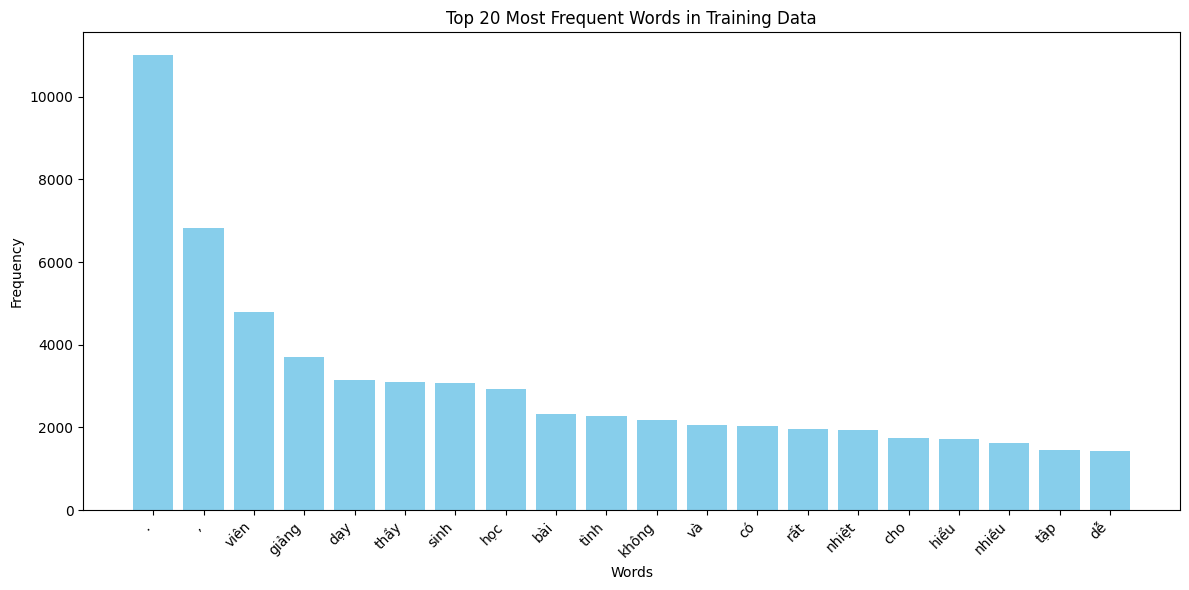

In [60]:


# Calculate word frequencies
all_words = [word for text in data_handler.train_dataset['text'] for word in text.split()]
word_counts = Counter(all_words)

# Get the most common words
num_top_words = 20
top_words = word_counts.most_common(num_top_words)

# Separate words and their counts for plotting
words = [word for word, count in top_words]
counts = [count for word, count in top_words]

# Create the bar graph
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {num_top_words} Most Frequent Words in Training Data')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()


# For both BERT - XLNet and vietnamese texts (this homework) and english texts (previous homework):

- Are there any differences in the evaluating performance in applying those 2 models for 2 datasets, i.e., vietnamese and english ? Analyze and visualize your results to prove your conclusion.

- How to improve the weaker approaches ?

### BERT Model.

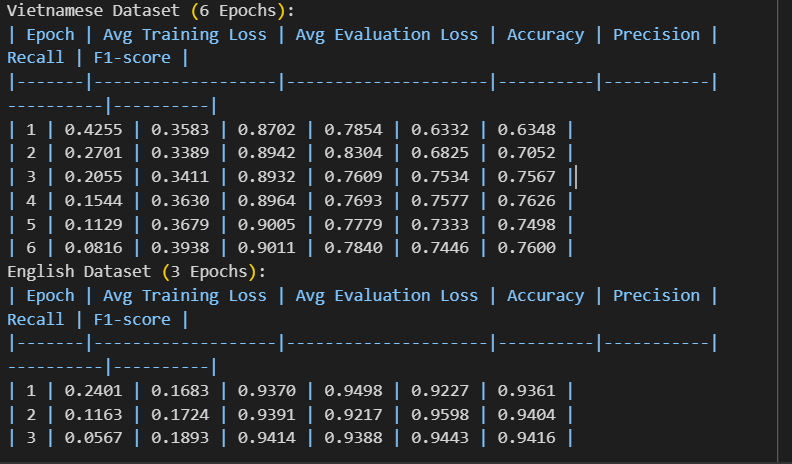

English: Achieved a higher peak F1-score (0.9416) and Accuracy (0.9414) compared to Vietnamese.
Vietnamese: Achieved a peak F1-score of 0.7626 (Epoch 4) and Accuracy of 0.9011 (Epoch 6).


- English: The evaluation loss started to slightly increase from Epoch 2 (0.1724) to Epoch 3 (0.1893), even though training loss decreased. This is a very mild sign of potential overfitting, but the F1-score and Accuracy still improved. The model appears robust.
- Vietnamese: This is more pronounced.
The lowest evaluation loss was at Epoch 2 (0.3389).
After Epoch 2, the evaluation loss consistently increased (0.3411, 0.3630, 0.3679, 0.3938) while the training loss continued to decrease. This is a clear indication of overfitting. The model was learning the training data too well and losing its ability to generalize to unseen evaluation data.
The best F1-score (0.7626) was achieved at Epoch 4, even though the evaluation loss was already higher than at Epoch 2. Accuracy peaked at Epoch 6, but this might be misleading given the increasing evaluation loss and fluctuating F1-score.

Metric Stability:
- English: Metrics were relatively stable and consistently high.
- Vietnamese: While accuracy generally trended upwards, Precision, Recall, and F1-score showed more fluctuation, especially after the onset of overfitting. The F1-score peaked at Epoch 4 (0.7626) and then slightly dropped.

### XLNet model.

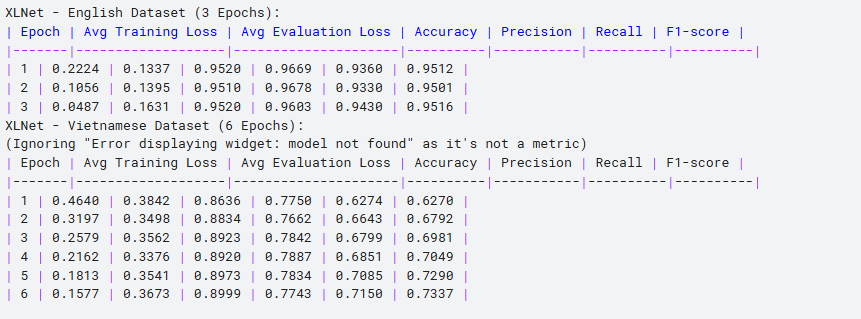

- English: Achieved a very high peak F1-score (0.9516 at Epoch 3, though 0.9512 at Epoch 1 was very close with lower eval loss) and Accuracy (0.9520 at Epochs 1 and 3).
- Vietnamese: Achieved a peak F1-score of 0.7337 (Epoch 6) and Accuracy of 0.8999 (Epoch 6).
- Training Convergence & Speed:
- English: The model reached a very low training loss (0.0487) in just 3 epochs. Evaluation metrics were high from the first epoch.
- Vietnamese: The training loss continued to decrease over 6 epochs (0.4640 down to 0.1577), indicating the model was still learning from the training data.

- English: Metrics were very stable and high. The slight dip in F1 at Epoch 2 was minimal.
- Vietnamese: Accuracy and F1-score generally trended upwards throughout the 6 epochs. Precision and Recall showed some fluctuations but also generally improved.

### How to improve the weaker approaches ?

- There are some reason.
- Dataset Size & Quality: The English dataset might be larger, cleaner, or more representative, allowing the model to learn more robust features.
- Language Complexity & Pre-training: Standard BERT models are often pre-trained on massive English corpora. While multilingual BERT exists, its Vietnamese component might be less extensive than its English one, or a monolingual Vietnamese BERT (like PhoBERT) might yield better results if a generic multilingual BERT was used.
- Task Difficulty: The classification task itself might be inherently more challenging for the Vietnamese dataset.
- Hyperparameters: The same hyperparameters might not be optimal for both languages/datasets.

### Some method I suggest.

Clean the data thoroughly:

Remove HTML tags, emojis, weird characters.

Fix spelling mistakes (if possible).

Normalize unicode characters.

Use a Vietnamese-friendly tokenizer:

Avoid standard English tokenizers.

PhoBERT tokenizer

SentencePiece or WordPiece trained on Vietnamese.

Handle class imbalance:

If one class appears much more often than others, your model might become biased.

Oversample the smaller classes.

Undersample the larger ones.

Use a weighted loss function to give more importance to minority classes.

Try SMOTE (synthetic data generation) – more common in tabular data, but text-based versions exist too.

Watch validation loss or F1-score.

Stop when performance stalls or drops on validation set – even if training loss keeps improving.
Helps prevent the model from "memorizing" training data.

Fine-tuning may benefit from slightly higher dropout rates.

Weight Decay:

Prevents weights from becoming too large.

Use the AdamW optimizer with weight decay (e.g., 0.01).

Label Smoothing:

Helps avoid overconfidence in predictions.

Can slightly improve generalization.